In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
from   sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

In [2]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\FOMCDrift\root\src")
from FOMCDataPreprocess import FOMCPreprocess

## Analyzing data

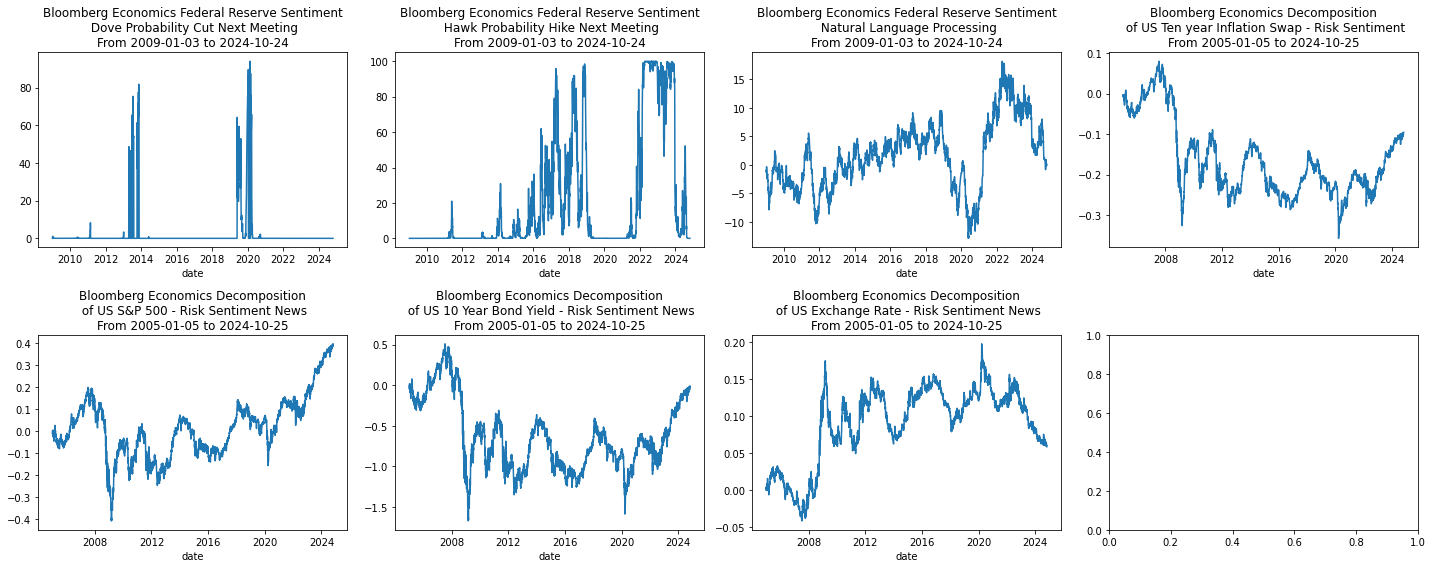

In [3]:
def plot_data() -> plt.Figure: 
    
    df_tmp    = FOMCPreprocess().get_sentiment()
    variables = (df_tmp[
        ["security", "Description"]].
        drop_duplicates().
        assign(
            Description = lambda x: x.Description.str.replace(
                "Reserve Sentiment", 
                "Reserve Sentiment\n")).
        assign(
            Description = lambda x: x.Description.str.replace(
                "Decomposition",
                "Decomposition\n")).
        set_index("security")
        ["Description"].
        to_dict())

    fig, axes = plt.subplots(ncols = (len(variables) // 2) + 1, nrows = 2, figsize = (20,8))

    for variable, ax in zip(variables.keys(), axes.flatten()):

        df_wider = (df_tmp.query(
            "security == @variable").
            drop(columns = ["Description"]).
            pivot(index = "date", columns = "security", values = "value"))

        df_wider.plot(
            ax     = ax,
            legend = False,
            title  = "{}\nFrom {} to {}".format(
                variables[variable],
                df_wider.index.min(),
                df_wider.index.max()))

    plt.tight_layout()
    
plot_data()

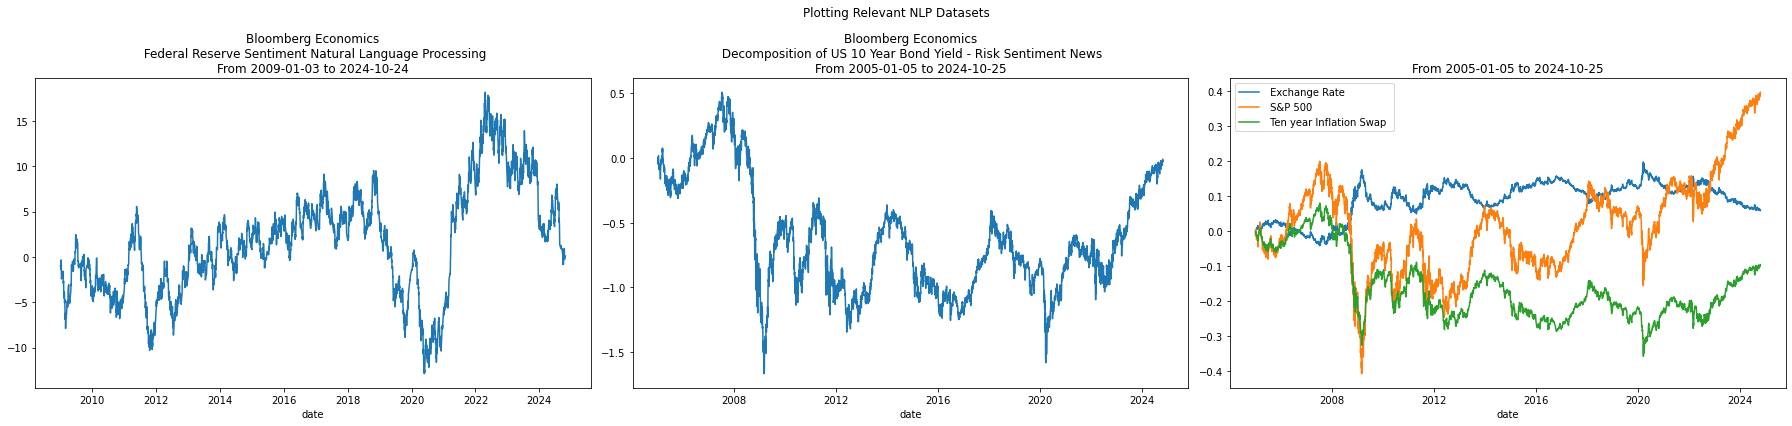

In [4]:
def plot_good_nlp() -> plt.Figure: 
    
    df_tmp  = (FOMCPreprocess().get_sentiment().assign(
        tmp         = lambda x: x.Description.str.split("US").str[1].str.split("-").str[0].fillna(x.security),
        Description = lambda x: x.Description.str.replace("cs", "cs\n")))

    var_dict = {
        "BE": ["BENLPFED"],
        "GF": ["APUSTYGF"],
        "AP": ["APUSISGF", "APUSSPGF", "APUSXRGF"]}

    fig, axes = plt.subplots(ncols = len(var_dict.keys()), figsize = (25,6))
    for var, ax in zip(var_dict.keys(), axes.flatten()):

        var_tmps = var_dict[var]
        df_plot  = df_tmp.query("security == @var_tmps")

        df_wider = (df_plot.drop(
            columns = ["Description"])
            [["date", "tmp", "value"]].
            rename(columns = {"tmp": ""}).
            pivot(index = "date", columns = "", values = "value"))

        df_wider.plot(
            ax = ax)

        if len(df_wider.columns.to_list()) < 2 : ax.get_legend().remove()

        if len(df_wider.columns.to_list()) == 1: ax.set_title("{}\nFrom {} to {}".format(
            df_plot.Description.iloc[0], 
            df_wider.index.min(), 
            df_wider.index.max()))

        if len(df_wider.columns.to_list()) > 2 : ax.set_title("From {} to {}".format(
            df_wider.index.min(),
            df_wider.index.max()))

    fig.suptitle("Plotting Relevant NLP Datasets")
    plt.tight_layout()
    
plot_good_nlp()

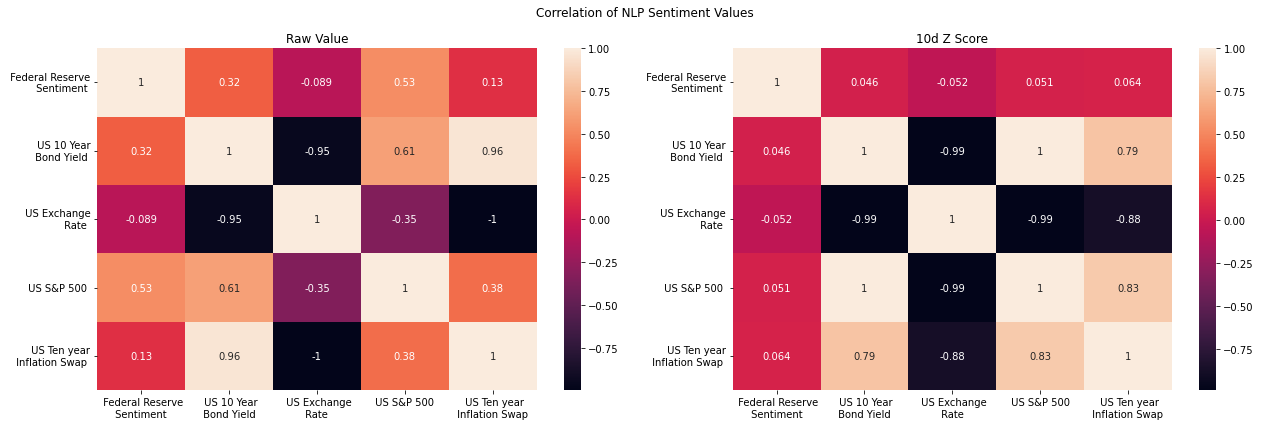

In [5]:
def plot_correlations() -> plt.Figure: 
    
    df_tmp = (FOMCPreprocess().prep_nlp().assign(
        Description = lambda x: (x.Description.str.split(
            "cs").
            str[1].
            str.split("-").str[0].
            str.split("of").str[-1].
            str.split("Nat").str[0].
            str.replace("Reserve", "Reserve\n").
            str.replace("Year", "Year\n").
            str.replace("Exchange", "Exchange\n").
            str.replace("year", "year\n"))))

    df_val_corr = (df_tmp[
        ["date", "Description", "value"]].
        pivot(index = "date", columns = "Description", values = "value").
        corr())

    df_zscore_corr = (df_tmp[
        ["date", "Description", "z_score"]].
        pivot(index = "date", columns = "Description", values = "z_score").
        corr())

    corrs = {
        "Raw Value": df_val_corr,
        "10d Z Score"  : df_zscore_corr}

    fig, axes = plt.subplots(ncols = len(corrs), figsize = (18,6))
    for corr, ax in zip(corrs.keys(), axes.flatten()):

        sns.heatmap(
            ax    = ax,
            data  = corrs[corr],
            annot = True)

        ax.set_title(corr)
        ax.set_xlabel("")
        ax.set_ylabel("")

    fig.suptitle("Correlation of NLP Sentiment Values")
    plt.tight_layout()
    
plot_correlations()